# Classify text with BERT

### Learning Objectives
1. Learn how to load a pre-trained BERT model from TensorFlow Hub
2. Learn how to build your own model by combining with a classifier
3. Learn how to train a BERT model by fine-tuning
4. Learn how to save your trained model and use it
5. Learn how to evaluate a text classification model

This lab will show you how to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

### Before you start

Please ensure you have a GPU (1 x NVIDIA Tesla T4 should be enough) attached to your Notebook instance to ensure that the training doesn't take too long. 

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


In [12]:
import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [19]:
import datetime
import shutil

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from google.cloud import aiplatform
from official.nlp import optimization  # to create AdamW optmizer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
tf.get_logger().setLevel("ERROR")

To check if you have a GPU attached. Run the following.

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


### Sentiment Analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

Let's take a look at a few reviews.

In [27]:
df = pd.read_csv('./classifier/data/ar_reviews_100k.tsv', sep='\t')
df.head()

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...


In [21]:
# remove mixed label
df = df[df['label']!='Mixed']

In [22]:
df['text'][0]

'ممتاز نوعا ما . النظافة والموقع والتجهيز والشاطيء. المطعم'

In [31]:
# split the data to train and test
# encode labels to be 0 & 1

msk = np.random.rand(len(df)) < 0.8

df_train, df_test = train_test_split(df, shuffle=True, stratify=df['label'], test_size=0.2)


#labels = tf.keras.utils.to_categorical(df['label'].values, 3)
oneencoder = OneHotEncoder()
labels_train = oneencoder.fit_transform(df_train['label'].values.reshape(-1, 1)).toarray()
features_train = df_train['text'].values


labels_test = oneencoder.transform(df_test['label'].values.reshape(-1, 1)).toarray()
features_test = df_test['text'].values

In [32]:
labels_test.shape

(20000, 3)

In [33]:
labels_train.shape

(79999, 3)

In [34]:
features_test.shape

(20000,)

In [35]:
df_train['label'].value_counts()

label
Positive    26667
Mixed       26666
Negative    26666
Name: count, dtype: int64

In [36]:
df_test['label'].value_counts()

label
Negative    6667
Mixed       6667
Positive    6666
Name: count, dtype: int64

## Loading models from TensorFlow Hub

For the purpose of this lab, we will be loading a model called Small BERT. Small BERT has the same general architecture as the original BERT but the has fewer and/or smaller Transformer blocks. 

Some other popular BERT models are BERT Base, ALBERT, BERT Experts, Electra. See the continued learning section at the end of this lab for more info. 

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yeld even better accuracy but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

### Choose a BERT model to fine-tune

In [7]:
# defining the URL of the smallBERT model to use
tfhub_handle_encoder = (
    "https://www.kaggle.com/models/jeongukjae/distilbert/frameworks/TensorFlow2/variations/multi-cased-l-6-h-768-a-12/versions/1"
)

# defining the corresponding preprocessing model for the BERT model above
tfhub_handle_preprocess = (
    "https://kaggle.com/models/jeongukjae/distilbert/frameworks/TensorFlow2/variations/multi-cased-preprocess/versions/2"
)

print(f"BERT model selected           : {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")

BERT model selected           : https://www.kaggle.com/models/jeongukjae/distilbert/frameworks/TensorFlow2/variations/multi-cased-l-6-h-768-a-12/versions/1
Preprocess model auto-selected: https://kaggle.com/models/jeongukjae/distilbert/frameworks/TensorFlow2/variations/multi-cased-preprocess/versions/2


## Preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

Use `hub.KerasLayer` to initialize the preprocessing

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

Call the preprocess model function and pass text_test

In [12]:
text_test = ['ممتاز نوعا ما . النظافة والموقع والتجهيز والشاطيء. المطعم']
text_preprocessed = bert_preprocess_model(text_test)

# This print box will help you inspect the keys in the pre-processed dictionary
print(f"Keys       : {list(text_preprocessed.keys())}")

# 1. input_word_ids is the ids for the words in the tokenized sentence
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')

# 2. input_mask is the tokens which we are masking (masked language model)
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')


Keys       : ['input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101   589 26259 28477 28475 28483   590 28496 28490 28475   589 28475]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]


In [35]:
text_test = ['ممتاز نوعا ما . النظافة والموقع والتجهيز والشاطيء. المطعم']
text_preprocessed = bert_preprocess_model(text_test)

# This print box will help you inspect the keys in the pre-processed dictionary
print(f"Keys       : {list(text_preprocessed.keys())}")

# 1. input_word_ids is the ids for the words in the tokenized sentence
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')

# 2. input_mask is the tokens which we are masking (masked language model)
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')


NameError: name 'bert_preprocess_model' is not defined

As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id` and `input_mask` ).

Some other important points:
- The input is truncated to 128 tokens. 

The text pre-processor is a TensorFlow model. This means that instead of pre-processing separately, we can include it as a layer in the model code.

### Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [14]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [15]:
bert_results = bert_model(text_preprocessed)

print(f"Loaded BERT: {tfhub_handle_encoder}")
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://www.kaggle.com/models/jeongukjae/distilbert/frameworks/TensorFlow2/variations/en-cased-l-6-h-768-a-12/versions/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.28033844 -0.02329977 -0.40485713 -0.31821167 -0.44380832  0.03117926
 -0.03902908 -0.05768996  0.14386004 -1.121127   -0.53882545  0.15056182]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.28033844 -0.02329977 -0.40485713 ...  0.00273048  0.5722147
   0.06915104]
 [ 0.3266366  -0.75488436 -0.5325857  ...  0.21432333  0.9574258
   0.01657147]
 [-0.2864752  -0.12382792 -0.37375325 ...  0.47723645  0.12630875
   0.43830597]
 ...
 [ 0.41460264 -0.49540305 -0.8801018  ...  0.57139534  0.9122761
   0.19051996]
 [ 0.00534315 -0.48737857 -0.5196555  ...  0.02541666  0.89087754
   0.4159014 ]
 [ 0.28753057 -0.25901377 -0.6318106  ...  0.3987626   0.92316073
   0.18527746]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

### Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can use copy the model's url to get to the documentation page.

The order of the layers in the model will be:
1. Input Layer
2. Pre-processing Layer
3. Encoder Layer
4. From the BERT output map, use pooled_output
5. Dropout layer
6. Dense layer with sigmoid activation

In [8]:
def build_classifier_model(dropout_rate=0.1):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='precessing_layer')

    encoder_inputs = preprocessing_layer(text_input)
    
    encoder = hub.KerasLayer(tfhub_handle_encoder,
                            trainable=True, name ='encoder_layer')
   
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]
    net = tf.keras.layers.Dropout(dropout_rate)(net)
    #net = tf.keras.layers.Dense(260, activation='relu')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name="classifier")(net)
    return tf.keras.Model(text_input, net)




NameError: name 'text_test' is not defined

In [10]:
# Let's check that the model runs with the output of the preprocessing model
text_test = ['ممتاز نوعا ما . النظافة والموقع والتجهيز والشاطيء. المطعم']
dropout_rate = 0.15
classifier_model = build_classifier_model(dropout_rate)
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.36099666 0.19302146 0.4459819 ]], shape=(1, 3), dtype=float32)


In [37]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 precessing_layer (KerasLayer)  {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                          
                                                                                                  
 encoder_layer (KerasLayer)     {'pooled_output': (  65190912    ['precessing_layer[0][0]', 

The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

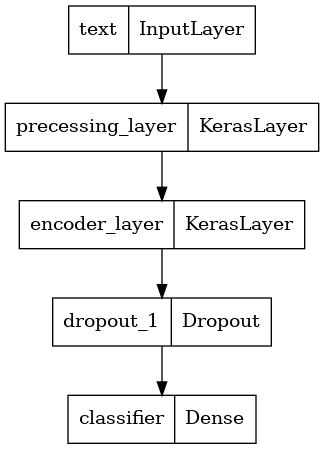

In [38]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


Define your loss and evaluation metrics here. Since it is a binary classification use BinaryCrossentropy and BinaryAccuracy

In [39]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [
    tf.metrics.CategoricalAccuracy()
    ]

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW).

In past labs, we have been using the Adam optimizer which is a popular choice. However, for this lab we will be using a new optimizier which is meant to improve generalization. The intuition and algoritm behind AdamW can be found in this paper [here](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [40]:
# specify training parameters

batch_size = 16
validation_split = 0.2
output_dir = './classifier'

model_export_path = os.path.join(output_dir, 'SavedModel')

if not os.path.exists(model_export_path):
    od.mkdir(model_export_path)

train_data_path = './classifier/data/ar_reviews_100k.tsv'
dropout_rate = 0.1
epochs = 1

steps_per_epoch = len(features_train) // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)


init_lr = 5e-5
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type="adamw",
)

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

Complile the model using the optimizer, loss and metrics you defined above.

In [41]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

Let's train the model for a few epochs.

In [56]:
history = classifier_model.fit(
    x=features_train, 
    y = labels_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data= (features_test, labels_test)
)

4990/4990 [==============================] - 1392s 278ms/step - loss: 0.8542 - categorical_accuracy: 0.5650 - val_loss: 0.7619 - val_categorical_accuracy: 0.6369


In [31]:
# Exporting the model with default serving function.
classifier_model.save(model_export_path)

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [38]:
loss, accuracy, precision, recall = classifier_model.evaluate(x=features_test, y=labels_test)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

417/417 [==============================] - 81s 194ms/step - loss: 0.3875 - binary_accuracy: 0.8111 - precision_1: 0.8150 - recall_1: 0.8081
Loss: 0.3875386714935303
Accuracy: 0.8111436367034912
Precision: 0.8149932026863098
Recall: 0.8080596923828125


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'precision_1', 'recall_1', 'val_loss', 'val_binary_accuracy', 'val_precision_1', 'val_recall_1'])


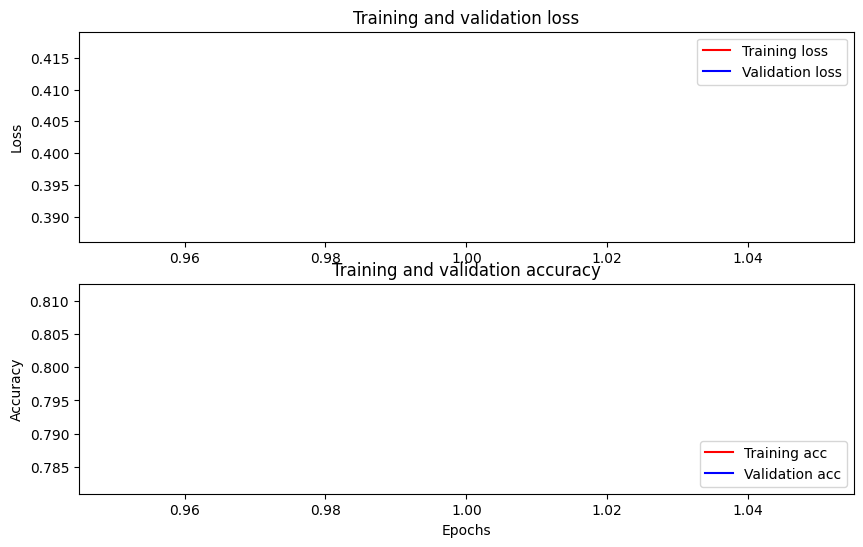

In [35]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, "r", label="Training loss")
# b is for "solid blue line"
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
# plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, "r", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# training job

### prepare files

In [75]:
%%writefile ./classifier/trainer/model.py

import os
import warnings

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


import datetime
import shutil

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from tensorflow.keras import callbacks
#from google.cloud import aiplatform
from official.nlp import optimization  # to create AdamW optmizer
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import numpy as np


#'./data/ar_reviews_100k.tsv'
def prepare_data(train_data_path):
    df = pd.read_csv(train_data_path, sep='\t')
    df = df[df['label']!='Mixed']
    
    msk = np.random.rand(len(df)) < 0.8
    df_train = df[msk]
    df_test = df[~msk]
    
    oneencoder = OneHotEncoder()

    labels_train = oneencoder.fit_transform(df_train['label'].values.reshape(-1, 1)).toarray()
    features_train = df_train['text'].values


    labels_test = oneencoder.transform(df_test['label'].values.reshape(-1, 1)).toarray()
    features_test = df_test['text'].values
    
    return features_train, labels_train, features_test, labels_test


def build_classifier_model(dropout_rate=0.1):
    
    # defining the URL of the smallBERT model to use
    tfhub_handle_encoder = (
        "https://www.kaggle.com/models/jeongukjae/distilbert/frameworks/TensorFlow2/variations/multi-cased-l-6-h-768-a-12/versions/1"
    )

    # defining the corresponding preprocessing model for the BERT model above
    tfhub_handle_preprocess = (
        "https://kaggle.com/models/jeongukjae/distilbert/frameworks/TensorFlow2/variations/multi-cased-preprocess/versions/2"
    )
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='precessing_layer')

    encoder_inputs = preprocessing_layer(text_input)
    
    encoder = hub.KerasLayer(tfhub_handle_encoder,
                            trainable=True, name ='encoder_layer')
   
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]
    net = tf.keras.layers.Dropout(dropout_rate)(net)
    #net = tf.keras.layers.Dense(260, activation='relu')(net)
    net = tf.keras.layers.Dense(3, activation="softmax", name="classifier")(net)
    return tf.keras.Model(text_input, net)


# Let's check that the model runs with the output of the preprocessing model.

def train_and_evaluate(hparam):
    
    batch_size = hparam['batch_size']
    validation_split = float(hparam['validation_split'])
    init_lr = hparam['lr']
    output_dir = hparam['output_dir']
    
    train_data_path = hparam['train_data_path']
    dropout_rate = hparam['dropout_rate']
    epochs = hparam['epochs']
    
    if tf.io.gfile.exists(output_dir):
        tf.io.gfile.rmtree(output_dir)
    
    model_export_path = os.path.join(output_dir, 'SavedModel')
    checkpoint_path = os.path.join(output_dir, "checkpoints")
    tensorboard_path = os.path.join(output_dir, "tensorboard")
    
    checkpoint_cb = callbacks.ModelCheckpoint(
        checkpoint_path, save_weights_only=True, verbose=1
    )
    
    tensorboard_cb = callbacks.TensorBoard(tensorboard_path, histogram_freq=1)

    classifier_model = build_classifier_model(dropout_rate)

    features, labels, features_test, labels_test = prepare_data(train_data_path)
    
    steps_per_epoch = len(features) // batch_size
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1 * num_train_steps)
    
    
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = [tf.metrics.CategoricalAccuracy()]
        


    optimizer = optimization.create_optimizer(
        init_lr=init_lr,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type="adamw",
    )

    classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)



    history = classifier_model.fit(
        x=features, 
        y = labels, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data= (features_test, labels_test), 
        callbacks=[checkpoint_cb, tensorboard_cb]
    )


    # Exporting the model with default serving function.
    classifier_model.save(model_export_path)
    return history

Overwriting ./classifier/trainer/model.py


In [76]:
%%writefile ./classifier/trainer/task.py

"""Argument definitions for model training code in `trainer.model`."""

import argparse

from trainer import model

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--batch_size",
        help="Batch size for training steps",
        type=int,
        default=32,
    )
    parser.add_argument(
        "--validation_split",
        help="evalution percent",
        default=0.2,
        type=float
    )

    parser.add_argument(
        "--lr", help="learning rate for optimizer", type=float, default=0.001
    )

    parser.add_argument(
        "--output_dir",
        help="GCS location to write checkpoints and export models",

    )
    parser.add_argument(
        "--train_data_path",
        help="GCS location pattern of train files containing eval URLs",

    )
    parser.add_argument(
        "--dropout_rate",
        help = "drop_rate",
        type=float,
        default=0.15
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=5
    )
    args = parser.parse_args()
    hparams = args.__dict__

    model.train_and_evaluate(hparams)

Overwriting ./classifier/trainer/task.py


In [77]:
%%writefile ./classifier/trainer/__init__.py



Overwriting ./classifier/trainer/__init__.py


In [39]:
# Change below if necessary
PROJECT = !gcloud config get-value project  # noqa: E999
PROJECT = PROJECT[0]
BUCKET = 'arabic-char-classifier4'
REGION = "us-central1"

OUTDIR = f"gs://{BUCKET}/classifier/"


IMAGE_NAME='classifier_training_container4'

%env PROJECT=$PROJECT
%env BUCKET=$BUCKET
%env REGION=$REGION
%env OUTDIR=$OUTDIR
%env TFVERSION=2.8
%env IMAGE_NAME=$IMAGE_NAME

env: PROJECT=qwiklabs-asl-00-05fccb34ed23
env: BUCKET=arabic-char-classifier4
env: REGION=us-central1
env: OUTDIR=gs://arabic-char-classifier4/classifier/
env: TFVERSION=2.8
env: IMAGE_NAME=classifier_training_container4


In [ ]:
run a test before start training

In [37]:
%%bash


TRAIN_DATA_PATH=./classifier/data/ar_reviews_100k.tsv
OUTPUT_DIR=../SavedModel/
BATCH_SIZE=8
VALIDATION_SPLIT=0.2
DROPOUT_RATE=0.15
EPOCHS=1
LR=5e-5

test ${OUTPUT_DIR} && rm -rf ${OUTPUT_DIR}
export PYTHONPATH=${PYTHONPATH}:${PWD}/classifier

python3 -m trainer.task \
--output_dir $OUTPUT_DIR \
--train_data_path $TRAIN_DATA_PATH \
--batch_size $BATCH_SIZE \
--validation_split $VALIDATION_SPLIT \
--dropout_rate $DROPOUT_RATE \
--epochs $EPOCHS \
--lr $LR


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/jupyter/arabic-char-classifier/classifier/trainer/task.py", line 51, in <module>
    model.train_and_evaluate(hparams)
  File "/home/jupyter/arabic-char-classifier/classifier/trainer/model.py", line 102, in train_and_evaluate
    classifier_model = build_classifier_model(dropout_rate)
  File "/home/jupyter/arabic-char-classifier/classifier/trainer/model.py", line 61, in build_classifier_model
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='precessing_layer')
  File "/opt/conda/lib/python3.10/site-packages/tensorflow_hub/keras_layer.py", line 157, in __init__
    self._func = load_module(handle, tags, self._load_options)
  File "/opt/conda/lib/python3.10/site-packages/tensorflow_hub/keras_layer.py",

Error while terminating subprocess (pid=1722437): 


In [40]:
%%writefile ./classifier/Dockerfile
FROM us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-12.py310

RUN pip install tensorflow-hub
RUN pip install tf-models-official==2.13.2
RUN pip install scikit-learn

COPY . /code

WORKDIR /code

ENTRYPOINT ["python3", "-m", "trainer.task"]

Overwriting ./classifier/Dockerfile


### prepare the environment

In [41]:
%%bash

PROJECT_DIR=$(cd ./classifier && pwd)

DOCKERFILE=$PROJECT_DIR/Dockerfile
IMAGE_URI=gcr.io/$PROJECT/$IMAGE_NAME

docker build $PROJECT_DIR -f $DOCKERFILE -t $IMAGE_URI

docker push $IMAGE_URI

Sending build context to Docker daemon  850.9MB
Step 1/7 : FROM us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-12.py310
 ---> bd2bbbab7d71
Step 2/7 : RUN pip install tensorflow-hub
 ---> Using cache
 ---> 517584367e50
Step 3/7 : RUN pip install tf-models-official==2.13.2
 ---> Using cache
 ---> 5d151aace5a5
Step 4/7 : RUN pip install scikit-learn
 ---> Using cache
 ---> 4fe5a1d4f39b
Step 5/7 : COPY . /code


Error processing tar file(exit status 1): write /code/SavedModel/variables/variables.data-00000-of-00001: no space left on device


Using default tag: latest
The push refers to repository [gcr.io/qwiklabs-asl-00-05fccb34ed23/classifier_training_container4]
7afed50cfa69: Preparing
09346dfb16c4: Preparing
1fb6ba705304: Preparing
67a672eb4eab: Preparing
e42695c7b436: Preparing
e42695c7b436: Preparing
7e34967c8575: Preparing
19c1ff49a1a3: Preparing
724eb7d1e386: Preparing
e7df186da59e: Preparing
e7df186da59e: Preparing
d9e5455afa58: Preparing
a4f1c7b5b5c5: Preparing
1eeca563762d: Preparing
b3f8d9df367e: Preparing
29e2658ae6ea: Preparing
228616cf4f10: Preparing
ae32b7336b96: Preparing
ae32b7336b96: Preparing
ea7b0ccc272e: Preparing
01d4173a3960: Preparing
c235d251a607: Preparing
f2833e4d69b4: Preparing
49fc5a524f1f: Preparing
e175e85d3600: Preparing
55bfb3527de7: Preparing
ee67859f37c6: Preparing
ed7e041f0699: Preparing
0235cf47cbae: Preparing
2971cdbb4b45: Preparing
8374b2bc65e7: Preparing
3b93a6feba89: Preparing
b15400eb0fa7: Preparing
29ecaf0c2ae0: Preparing
41e673079fce: Preparing
cda9215846ee: Preparing
c5eafb4bee8

In [65]:
%%bash
gcloud config set project $PROJECT
gcloud config set ai/region $REGION

Updated property [core/project].
Updated property [ai/region].


In [81]:
%%bash
# Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
    echo -e "Bucket exists, let's not recreate it."
else
    echo "Creating a new GCS bucket."
    gsutil mb -l ${REGION} gs://${BUCKET}
    echo "\nHere are your current buckets:"
    gsutil ls
fi

Creating a new GCS bucket.


Creating gs://arabic-char-classifier4/...


\nHere are your current buckets:
gs://arabic-char-classifier/
gs://arabic-char-classifier4/
gs://arabic-sentiment-analysis/
gs://artifacts.qwiklabs-asl-00-05fccb34ed23.appspot.com/
gs://cloud-ai-platform-46477855-4c0e-426a-84c4-9b588bc8ee51/
gs://medhat_bucket/
gs://qwiklabs-asl-00-05fccb34ed23/
gs://qwiklabs-asl-00-05fccb34ed23-vertex-pipelines-europe-west4/
gs://qwiklabs-asl-00-05fccb34ed23-vertex-pipelines-us-central1/
gs://qwiklabs-asl-00-05fccb34ed23_cloudbuild/


In [82]:
%%bash
gsutil ls -Lb gs://$BUCKET | grep "gs://\|Location"
echo $REGION

gs://arabic-char-classifier4/ :
	Location type:			region
	Location constraint:		US-CENTRAL1
us-central1


In [58]:
!gsutil cp ./classifier/data/ar_reviews_100k.tsv gs://$BUCKET/classifier/data/

Copying file://./classifier/data/ar_reviews_100k.tsv [Content-Type=text/tab-separated-values]...
- [1 files][ 51.8 MiB/ 51.8 MiB]                                                
Operation completed over 1 objects/51.8 MiB.                                     


In [42]:
%%bash

# Output directory and jobID
TIMESTAMP=$(date -u +%Y%m%d_%H%M%S)
OUTDIR=gs://${BUCKET}/classifier_$TIMESTAMP
JOB_NAME=classifier_$TIMESTAMP
echo ${OUTDIR} ${REGION} ${JOB_NAME}


# Vertex AI machines to use for training
MACHINE_TYPE=n1-standard-16
ACCELERATOR_TYPE=NVIDIA_TESLA_T4
REPLICA_COUNT=1

# GCS paths
GCS_PROJECT_PATH=gs://$BUCKET/classifier
DATA_PATH=$GCS_PROJECT_PATH/data
TRAIN_DATA_PATH=gs://qwiklabs-asl-00-05fccb34ed23/classifier/data/ar_reviews_100k.tsv
BATCH_SIZE=32
VALIDATION_SPLIT=0.2
DROPOUT=0.4
EPOCHS=10
LR=5e-5

IMAGE_NAME=$IMAGE_NAME
IMAGE_URI=gcr.io/$PROJECT/$IMAGE_NAME

WORKER_POOL_SPEC="machine-type=$MACHINE_TYPE,\
accelerator-type=$ACCELERATOR_TYPE,\
replica-count=$REPLICA_COUNT,\
container-image-uri=$IMAGE_URI"

OUTPUT_DIR=$OUTDIR
ARGS="--batch_size=$BATCH_SIZE,\
--validation_split=$VALIDATION_SPLIT,\
--lr=$LR,\
--output_dir=$OUTPUT_DIR,\
--train_data_path=$TRAIN_DATA_PATH,\
--dropout_rate=$DROPOUT,\
--epochs=$EPOCHS"

gcloud ai custom-jobs create \
  --region=$REGION \
  --display-name=$JOB_NAME \
  --worker-pool-spec=$WORKER_POOL_SPEC \
  --args="$ARGS"

gs://arabic-char-classifier4/classifier_20231218_093403 us-central1 classifier_20231218_093403


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
CustomJob [projects/1033908600341/locations/us-central1/customJobs/6132362482846531584] is submitted successfully.

Your job is still active. You may view the status of your job with the command

  $ gcloud ai custom-jobs describe projects/1033908600341/locations/us-central1/customJobs/6132362482846531584

or continue streaming the logs with the command

  $ gcloud ai custom-jobs stream-logs projects/1033908600341/locations/us-central1/customJobs/6132362482846531584


In [43]:
!gcloud ai custom-jobs stream-logs projects/1033908600341/locations/us-central1/customJobs/6132362482846531584

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
INFO	2023-12-18 09:34:05 +0000	service	Waiting for job to be provisioned.
INFO	2023-12-18 09:38:06 +0000	workerpool0-0	Epoch 1/10
INFO	2023-12-18 09:42:23 +0000	workerpool0-0	
INFO	2023-12-18 09:42:23 +0000	workerpool0-0	   1/2507 [..............................] - ETA: 7:20:18 - loss: 1.2001 - categorical_accuracy: 0.312
INFO	2023-12-18 09:42:23 +0000	workerpool0-0	   2/2507 [..............................] - ETA: 20:05 - loss: 1.1976 - categorical_accuracy: 0.3594 
INFO	2023-12-18 09:42:23 +0000	workerpool0-0	   3/2507 [..............................] - ETA: 20:07 - loss: 1.2546 - categorical_accuracy: 0.322
INFO	2023-12-18 09:42:23 +0000	workerpool0-0	   4/2507 [..............................] - ETA: 20:02 - loss: 1.2360 - categorical_accuracy: 0.343
INFO	2023-12-18 09:42:23 +0000	workerpool0-0	   5/2507 [..............................] - ETA: 20:01 - loss: 1.2456 - categorical_accuracy: 0.337
INFO	2023-12-18 09:42:23 +

In [11]:
import tensorboard


%load_ext tensorboard
%tensorboard --logdir 'gs://arabic-char-classifier4/classifier_20231215_163828/tensorboard' --port=8008

## (Optional) Deploy your model on Vertex AI to get online predictions

We'll export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

Next, print the signature of your saved model using the SavedModel Command Line Interface command saved_model_cli. You can read more about the command line interface and the show and run commands it supports in the [documentation here](https://www.tensorflow.org/guide/saved_model#overview_of_commands).

In [10]:
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
PROJECT = !gcloud config list --format 'value(core.project)' 2>/dev/null
PROJECT = PROJECT[0]
BUCKET = PROJECT
REGION = "us-central1"
MODEL_DISPLAYNAME = f"arabic-classifier-{TIMESTAMP}"

print(f"MODEL_DISPLAYNAME: {MODEL_DISPLAYNAME}")


os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

MODEL_DISPLAYNAME: arabic-classifier-20231215063544


In [11]:
EXPORT_PATH='gs://qwiklabs-asl-00-05fccb34ed23/classifier_20231214_084810/SavedModel/SavedModel/'

SERVING_CONTAINER_IMAGE_URI=(
    "us-docker.pkg.dev/vertex-ai/prediction/tf2-gpu.2-13:latest"
)
uploaded_model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAYNAME,
    artifact_uri=EXPORT_PATH,
    serving_container_image_uri=SERVING_CONTAINER_IMAGE_URI,
)

Creating Model
Create Model backing LRO: projects/1033908600341/locations/us-central1/models/4123096036392566784/operations/206171005872242688
Model created. Resource name: projects/1033908600341/locations/us-central1/models/4123096036392566784@1
To use this Model in another session:
model = aiplatform.Model('projects/1033908600341/locations/us-central1/models/4123096036392566784@1')


In [12]:
MACHINE_TYPE = "n1-standard-4"
ACCELERATOR_TYPE='NVIDIA_TESLA_T4'
endpoint = uploaded_model.deploy(
    machine_type=MACHINE_TYPE,
    accelerator_type=ACCELERATOR_TYPE,
    accelerator_count=1,
)

Creating Endpoint
Create Endpoint backing LRO: projects/1033908600341/locations/us-central1/endpoints/1064408619547623424/operations/8532200816973447168
Endpoint created. Resource name: projects/1033908600341/locations/us-central1/endpoints/1064408619547623424
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/1033908600341/locations/us-central1/endpoints/1064408619547623424')
Deploying model to Endpoint : projects/1033908600341/locations/us-central1/endpoints/1064408619547623424
Deploy Endpoint model backing LRO: projects/1033908600341/locations/us-central1/endpoints/1064408619547623424/operations/228126054055673856
Endpoint model deployed. Resource name: projects/1033908600341/locations/us-central1/endpoints/1064408619547623424


Once the model has been uploaded to the endpoint, you can query the endpoint to get predictions from the model. The query has to be a list of instances. From the signature of the model we see that the key for the query has to be `text`.

In [13]:
instances = [
    {"text": ["لم اجد فيها شيء مميز لا اعتقد انها تستحق "]},
    {"text": ["المطعم كان سى للغاية والمكان غير نظيف"]},
    {"text": ["كان دكتور شاطر ومميز جدا"]},
]

In [14]:



response = endpoint.predict(instances)

In [15]:
print(" prediction:", response.predictions)

 prediction: [[1.10273168e-05], [0.00986789819], [0.957171202]]


In [16]:
res = endpoint.predict(["تاكومى مدرس شاطر وذكى"])

In [17]:
np.round(res.predictions[0][0])

1.0

## streamlit Application

In [44]:
from pyngrok import ngrok 
import streamlit as st 


In [45]:
ngrok.kill()

#take the token for deployment
NGROK_AUTH_TOKEN="2ZZIMNbw1np7iRfv6d38uCodB9t_UKuBFNYZN445YMrHEAGQ"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

In [46]:
ngrok.connect(8501)

<NgrokTunnel: "https://ff3a-34-121-232-165.ngrok-free.app" -> "http://localhost:8501">

In [47]:
%%writefile app.py

import streamlit as st
import time
from google.cloud import aiplatform
import numpy as np
st.title('arabic sentiment Classifier')


# [START aiplatform_predict_custom_trained_model_sample]
from typing import Dict, List, Union

from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value


def predict_custom_trained_model_sample(
    project: str,
    endpoint_id: str,
    instances: Union[Dict, List[Dict]],
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
):
    """
    `instances` can be either single instance of type dict or a list
    of instances.
    """
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    # The format of each instance should conform to the deployed model's prediction input schema.
    instances = instances if isinstance(instances, list) else [instances]
    instances = [
        json_format.ParseDict(instance_dict, Value()) for instance_dict in instances
    ]
    parameters_dict = {}
    parameters = json_format.ParseDict(parameters_dict, Value())
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )
    
    # The predictions are a google.protobuf.Value representation of the model's predictions.
    predictions = response.predictions
    return predictions


# [END aiplatform_predict_custom_trained_model_sample]
st.markdown("Welcome")


def main():
    feedback = st.text_input('Feedback')
    class_btn = st.button("Classify") 
        
    if class_btn:
        if feedback is None:
            st.write("Invalid command, please type a feedback")
        else:
            #with st.spinner('Model working....'):
                
            predictions = predict(feedback)
            st.success('Classified')
            st.write(predictions)
            
            if predictions=='Postive':
                st.image('./emotions/happy.jpg')
            else:
                st.image('./emotions/sad.png')


def predict(text):

    res = predict_custom_trained_model_sample(
    project="1033908600341",
    endpoint_id="1064408619547623424",
    location="us-central1",
    instances={ "text": text}
)
    if np.round(res[0][0]) == 1.0:
        return 'Postive'
    else:
        return 'Negative'
    
    

if __name__ == "__main__":
    main()

Overwriting app.py


In [48]:
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Network URL: http://10.128.0.7:8501
  External URL: http://34.121.232.165:8501

^C
  Stopping...


In [196]:

# [START aiplatform_predict_custom_trained_model_sample]
from typing import Dict, List, Union

from google.cloud import aiplatform
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value


def predict_custom_trained_model_sample(
    project: str,
    endpoint_id: str,
    instances: Union[Dict, List[Dict]],
    location: str = "us-central1",
    api_endpoint: str = "us-central1-aiplatform.googleapis.com",
):
    """
    `instances` can be either single instance of type dict or a list
    of instances.
    """
    # The AI Platform services require regional API endpoints.
    client_options = {"api_endpoint": api_endpoint}
    # Initialize client that will be used to create and send requests.
    # This client only needs to be created once, and can be reused for multiple requests.
    client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
    # The format of each instance should conform to the deployed model's prediction input schema.
    instances = instances if isinstance(instances, list) else [instances]
    instances = [
        json_format.ParseDict(instance_dict, Value()) for instance_dict in instances
    ]
    parameters_dict = {}
    parameters = json_format.ParseDict(parameters_dict, Value())
    endpoint = client.endpoint_path(
        project=project, location=location, endpoint=endpoint_id
    )
    response = client.predict(
        endpoint=endpoint, instances=instances, parameters=parameters
    )
    print("response")
    print(" deployed_model_id:", response.deployed_model_id)
    # The predictions are a google.protobuf.Value representation of the model's predictions.
    predictions = response.predictions
    return predictions


# [END aiplatform_predict_custom_trained_model_sample]

## Cleanup
When deploying a model to an endpoint for online prediction, the minimum min-replica-count is 1, and it is charged per node hour. So let's delete the endpoint to reduce unnecessary charges. Before we can delete the endpoint, we first undeploy all attached models.

In [199]:
endpoint.undeploy_all()

0.975059092

...then delete the endpoint.

In [ ]:
endpoint.delete()

## Continued Learning

In this lab, we chose small BERT to train our text classifier. There are other pre-trained BERT models which you can find here. Consider experiementing with some of these. However, remember that the bigger the model you choose to fine-tune, the longer it will take to train.

There are 
  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature.

Aside from the models available above, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yeld even better accuracy but they are too big to be fine-tuned on a single GPU.